<div align="right">
  Christopher Lüken-Winkels, Lukas Blecher
</div>
# Exercise 2
## 2 Data Preparation

In [6]:
#import standard libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits
from sklearn import model_selection
from itertools import chain

In [7]:
digits = load_digits ()
print(digits.keys ()) #Python 3
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [8]:
# filter out all 1's and 7's
# split into train and test data
X_all = data[(target==1)|(target==7)]
y_all = target[(target==1)|(target==7)]
X_train, X_test, y_train , y_test = model_selection.train_test_split(X_all,y_all,test_size = 0.4,random_state = 0)

In [9]:
#verify 3/2 split:
len(X_train)/len(X_test)

1.4896551724137932

### 2.1 Dimension Reduction

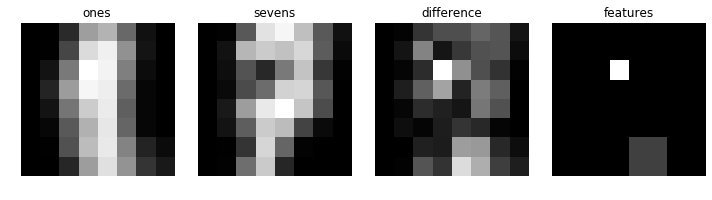

In [5]:
#first look at average of all ones and sevens to identify hot pixels
ones,sevens=images[target==1],images[target==7]
fig = plt.figure(figsize = (10,3))
plt.gray()
plt.subplot('141'); plt.axis('off')
plt.imshow(np.mean(ones,axis=0), interpolation = "nearest")
plt.title('ones')
plt.subplot('142'); plt.axis('off')
plt.imshow(np.mean(sevens,axis=0), interpolation = "nearest")
plt.title('sevens')
plt.subplot('143'); plt.axis('off')
plt.imshow(abs(np.mean(ones,axis=0)-np.mean(sevens,axis=0)), interpolation = "nearest")
plt.title('difference')
plt.subplot('144'); plt.axis('off')
f=np.zeros((8,8))
f[2,3]=1
f[7,4]=f[7,5]=f[6,4]=f[6,5]=.25
plt.imshow(f, interpolation = "nearest")
plt.title('features')
fig.tight_layout(); plt.show()

In the difference plot we can se one very bright pixel in particular. It would be smart to take that pixel value as our first feature. For the second feature we can take an also quite bright pixel region in the lower part of the picture. The average of the four brighter pixel might be a good feature

In [10]:
#reduce dimension function
def reduce_dim(x):
    red=np.zeros((x.shape[0], 2), dtype = np.float64)
    #iterate over the instances
    for i in range(x.shape[0]):
        red[i,0]=x[i,2*8+3]
        red[i,1]=(x[i,7*8+4]+x[i,7*8+5]+x[i,6*8+4]+x[i,6*8+5])/4
    return red

### 2.2 Scatterplot

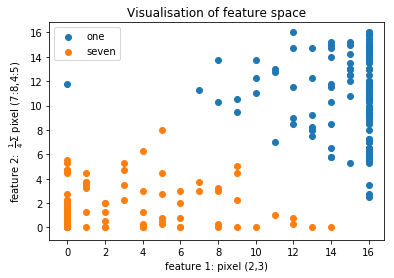

In [7]:
plt.scatter(*reduce_dim(X_train[y_train==1]).T,label='one')
plt.scatter(*reduce_dim(X_train[y_train==7]).T,label='seven')
plt.title('Visualisation of feature space')
plt.xlabel('feature 1: pixel (2,3)')
plt.ylabel('feature 2:  $\\frac{1}{4} \Sigma$ pixel (7:8,4:5)')
plt.legend()
plt.show()

## 3 Neares Mean
### 3.1 Implement the nearest mean classifier

In [11]:
def nearest_mean(training_features,training_labels,test_features):
    #list of features:
    features=np.nonzero(np.bincount(training_labels))[0] #is always [1,7] in our example
    #compute per-class centroids
    mu=[]
    #not a bad loop: only 2 iterations. 
    for i in range(len(features)):
        mu.append(np.mean(training_features[training_labels==features[i]],axis=0))
    mu=np.array(mu)
    #now classify the test_features:
    #calculate the distance matrix
    dist=np.sqrt(np.sum(np.square(test_features[:,None]-mu),axis=2))
    #decide which class each element most likley represents
    classes=np.argmin(dist,axis=1)
    #convert from indices of features to the features and return result
    return np.array(list(map(features.__getitem__,classes)))

In [12]:
training_features,test_features=reduce_dim(X_train),reduce_dim(X_test)
guessed_test_labels=nearest_mean(training_features,y_train,test_features)
print('Error:',100*(1-np.count_nonzero(guessed_test_labels==y_test)/len(y_test)),'%')

Error: 0.0 %


### 3.2 Visualize the decision regions

In [10]:
#both features are normalized to 16
x,y=np.linspace(-1,17,200),np.linspace(-1,17,200)
X,Y=np.meshgrid(x,y)

In [11]:
#find means:
mu=[np.mean(reduce_dim(X_train[y_train==1]),axis=0),np.mean(reduce_dim(X_train[y_train==7]),axis=0)]

In [13]:
#our classifier is just a nearest neighbor classifier with the only two objects beeing the two means. 
#So our decision region will just be a line through the middle of the two means
def decision_line(x,y,mu): #returns -1 for (x,y) if under and 1 if (x,y) is over the line
    mean=np.mean(mu,axis=0)
    #y=mx+c
    m=-mean[0]/mean[1]
    c=mean[1]-m*mean[0]
    diff=y-(m*x+c)
    return diff/abs(diff)

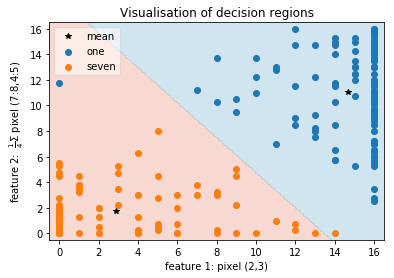

In [95]:
plt.contourf(X, Y, decision_line(X,Y,mu),1,alpha=.3,cmap=plt.cm.RdBu)
#plt.colorbar()
plt.scatter(*reduce_dim(X_train[y_train==1]).T,label='one')
plt.scatter(*reduce_dim(X_train[y_train==7]).T,label='seven')
plt.title('Visualisation of decision regions')
plt.xlabel('feature 1: pixel (2,3)')
plt.ylabel('feature 2:  $\\frac{1}{4} \Sigma$ pixel (7:8,4:5)')
plt.plot(*mu[0],'*',color='black',label='mean')
plt.plot(*mu[1],'*',color='black')
plt.ylim(-0.5,16.5)
plt.xlim(-0.5,16.5)
plt.legend(framealpha=.5)
plt.show()

## 4 QDA
### 4.1 Implement QDA Training

In [14]:
def fit_qda(training_features, training_labels):
    #list of features:
    features=np.nonzero(np.bincount(training_labels))[0] #is always [1,7] in our example
    #compute per-class centroids
    mu=[]
    #not a bad loop: only 2 iterations. 
    for i in range(len(features)):
        mu.append(np.mean(training_features[training_labels==features[i]],axis=0))
    mu=np.array(mu)
    covmat = []
    for i in range(len(mu)):
        X = training_features[training_labels==features[i]]
        X_center = X - mu[i]
        covmat.append(np.sum(np.einsum('ij,ik->ijk',X_center,X_center),axis=0)/len(X_center))
    covmat = np.array(covmat)
    #priors are equally distributed since no class is special
    p = np.ones(len(features))/len(features)    #!!! not right yet!!!
    return mu,covmat,p

### 4.2 Implement QDA Prediction

In [15]:
def predict_qda(mu, covmat, p, test_features):
    b = np.log(2 * np.pi * np.linalg.det(covmat)) - np.log(p)
    Y = []
    #loop only over features
    for k in range(len(mu)):
        X_center = test_features - mu[k]
        y = np.sum(np.multiply(np.dot(X_center,np.linalg.inv(covmat[k])),X_center),axis=1) + b[k]
        Y.append(y)
    #return np.argmin(Y,axis=0) #if we want 0 for 1 and 1 for 7
    return np.array(list(map([1,7].__getitem__,np.argmin(Y,axis=0)))) #if we want the real digit.

In [351]:
#training:
mu,covmat,p=fit_qda(training_features,y_train)
#training error:
print('training error:',100*(1-np.count_nonzero(predict_qda(mu,covmat,p,training_features)==y_train)/len(y_train)),'%')
#test error:
print('test error:',100*(1-np.count_nonzero(predict_qda(mu,covmat,p,test_features)==y_test)/len(y_test)),'%')

training error: 0.462962962962965 %
test error: 0.0 %


### 4.3 Visualization

In [352]:
#both features are normalized to 16
x,y=np.linspace(-1,17,200),np.linspace(-1,17,200)
X,Y=np.meshgrid(x,y)
grid=np.vstack(map(np.ravel, np.meshgrid(x,y))).T
mu,covmat,p=fit_qda(training_features,y_train)

In [16]:
def DDGaussian(x,covmat,mu):
    return np.exp(-.5*np.sum(np.multiply(np.dot(x-mu,np.linalg.inv(covmat)),\
                                         (x-mu)),axis=1))/np.sqrt((2*np.pi)**len(covmat)*np.linalg.det(covmat))

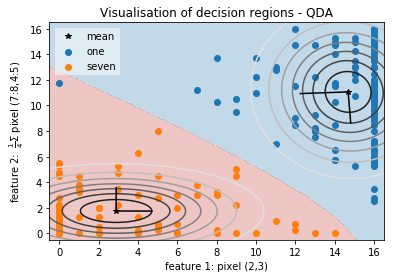

In [354]:
plt.contourf(X, Y,np.array(predict_qda(mu,covmat,p,grid)).reshape((200,200)) ,1,alpha=.3,cmap=plt.cm.RdBu_r)
#plt.colorbar()
plt.scatter(*reduce_dim(X_train[y_train==1]).T,label='one')
plt.scatter(*reduce_dim(X_train[y_train==7]).T,label='seven')
plt.title('Visualisation of decision regions - QDA')
plt.xlabel('feature 1: pixel (2,3)')
plt.ylabel('feature 2:  $\\frac{1}{4} \Sigma$ pixel (7:8,4:5)')
for i in range(2):
    plt.contour(X,Y,DDGaussian(grid,covmat[i],mu[i]).reshape((200,200)),cmap=plt.cm.binary)
    val,vec=np.linalg.eig(covmat[i])
    for j in range(2):
        p=(mu[i]+vec[:,j]*np.sqrt(val[i]))
        plt.plot([mu[i][0],p[0]],[mu[i][1],p[1]],color='black')
plt.plot(*mu[0],'*',color='black',label='mean')
plt.plot(*mu[1],'*',color='black')
plt.ylim(-0.5,16.5)
plt.xlim(-0.5,16.5)
plt.legend(framealpha=.5)
plt.show()

We can see one misclassification. That means our training error is $\frac{1}{216}=0.46\%$. 

<span style =" color : red ;font-weight : bold ">#todo: where do training errors in QDA stem from? (still not that good :D) </span >

In the nearest neighbor classifier each training feature is treated seperately. In case of QDA we look at the whole cluster where the impact of single points that are far away from the mean is regulated by the (many) closer points. This generalization over all points can lead to misclassifications of points that do not obey the chosen generalization or that are very unpropable.

### 4.4 Performance evaluation

In [17]:
def cross_validate(data, target,L):
    #shuffle target and data in unison
    permutation = np.random.permutation(len(data))
    data,target = data[permutation],target[permutation]
    X_folds,y_folds= np.array(np.array_split(data,L)),np.array(np.array_split(target,L))
    error_rates = []
    for n in range(L):
        # construct train and test set from folds
        X_train_f = np.concatenate([X_folds[i] for i in range(L) if i != n])
        X_test_f = X_folds[n]
        y_train_f = np.concatenate([y_folds[i] for i in range(L) if i != n])
        y_test_f = y_folds[n]
        #print(X_test_f.shape,X_train_f.shape,y_train_f.shape,y_test_f.shape)
        # train the QDA classifier
        mu,covmat,p=fit_qda(X_train_f,y_train_f)
        #result = predict_qda(mu,covmat,p,X_test_f)
        error_rates.append(100*(1-np.count_nonzero(predict_qda(mu,covmat,p,X_test_f)==y_test_f)/len(y_test_f)))
    return np.mean(error_rates), np.std(error_rates)

In [448]:
print(cross_validate(reduce_dim(X_all[1:]),y_all[1:],10))

(0.8333333333333337, 1.2729376930432894)


So in average we get an error of $(0.8\bar3 \pm 1.27)\%$.

## 5 LDA
### 5.1 Implement LDA Training

In [23]:
#works analogue to QDA Training
def fit_lda(training_features,training_labels):
    #list of features:
    features=np.nonzero(np.bincount(training_labels))[0] #is always [1,7] in our example
    #compute per-class centroids
    mu=[]
    #not a bad loop: only 2 iterations. 
    for i in range(len(features)):
        mu.append(np.mean(training_features[training_labels==features[i]],axis=0))
    mu=np.array(mu)
    covmat_wc = []
    p =[]
    for k in range (len(mu)):
        X = training_features[training_labels==features[k]]
        X_center = X - mu[k]
        covmat_wc.append(np.sum(np.einsum('ij,ik->ijk',X_center,X_center),axis=0))
        p.append(len(X_center)/len(training_features))
    covmat_wc = np.sum(np.array(covmat_wc),axis=0)/len(training_features)
    p = np.array(p)
    return mu, covmat_wc, p

### 5.2 Implement LDA Prediction

In [76]:
#works analogue to QDA Training
def predict_lda(mu, covmat, p, test_features):
    #b of qda:
    b = np.log(2 * np.pi * np.linalg.det(covmat)) - np.log(p)
    w_kT = []
    Y = []
    for k in range(len(mu)):
        #corrected b for lda
        b[k] = - b[k] - np.matmul(mu[k], np.matmul(np.linalg.inv(covmat), mu[k].T))
        w_kT.append(2 * np.matmul(mu[k], np.linalg.inv(covmat)))
    w_kT = np.array(w_kT)
    for k in range(len(mu)):
        Y.append(np.matmul(w_kT[k], test_features.T) + b[k])
    return np.array(list(map([1,7].__getitem__, np.argmax(Y,axis=0))))

In [80]:
#training:
mu_2,covmat_wc,p_2 = fit_lda(training_features,y_train)
#training error:
print('training error:',100*(1-np.count_nonzero(predict_lda(mu_2,covmat_wc,p_2,training_features)==y_train)/len(y_train)),'%')
#test error:
print('test error:',100*(1-np.count_nonzero(predict_lda(mu_2,covmat_wc,p_2,test_features)==y_test)/len(y_test)),'%')

training error: 0.462962962962965 %
test error: 0.0 %


Due to the choice of the representative features the clusters are well seperated by a straight line, which is why we get the same error rates. 

### 5.3 Visualization

In [81]:
#both features are normalized to 16
x, y = np.linspace(-1, 17, 200),np.linspace(-1, 17, 200)
X, Y = np.meshgrid(x, y)
grid = np.vstack(map(np.ravel, np.meshgrid(x, y))).T
mu_2, covmat_wc, p_2 = fit_lda(training_features, y_train)

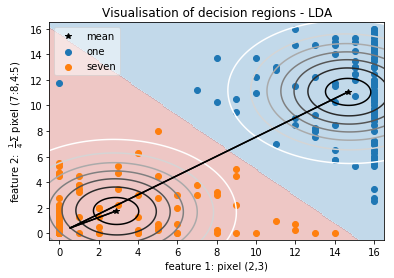

In [82]:
plt.contourf(X, Y,np.array(predict_lda(mu_2,covmat_wc,p_2,grid)).reshape((200,200)) ,1,alpha=.3,cmap=plt.cm.RdBu_r)
#plt.colorbar()
plt.scatter(*reduce_dim(X_train[y_train==1]).T,label='one')
plt.scatter(*reduce_dim(X_train[y_train==7]).T,label='seven')
plt.title('Visualisation of decision regions - LDA')
plt.xlabel('feature 1: pixel (2,3)')
plt.ylabel('feature 2:  $\\frac{1}{4} \Sigma$ pixel (7:8,4:5)')
for i in range(2):
    plt.contour(X,Y,DDGaussian(grid,covmat_wc,mu_2[i]).reshape((200,200)),cmap=plt.cm.binary)
    val,vec=np.linalg.eig(covmat_wc)
    for j in range(2):
        p=(mu_2[i]+vec[:,j]*np.sqrt(val[i]))
        plt.plot([mu_2[i][0],p_2[0]],[mu_2[i][1],p_2[1]],color='black')
plt.plot(*mu_2[0],'*',color='black',label='mean')
plt.plot(*mu_2[1],'*',color='black')
plt.ylim(-0.5,16.5)
plt.xlim(-0.5,16.5)
plt.legend(framealpha=.5)
plt.show()

<span style =" color : red ;font-weight : bold ">#todo: correct strange vectors  </span >

### 5.4 Performance evaluation

In [83]:
def cross_validate_lda(data, target,L):
    #shuffle target and data in unison
    permutation = np.random.permutation(len(data))
    data,target = data[permutation],target[permutation]
    X_folds,y_folds= np.array(np.array_split(data,L)),np.array(np.array_split(target,L))
    error_rates = []
    for n in range(L):
        # construct train and test set from folds
        X_train_f = np.concatenate([X_folds[i] for i in range(L) if i != n])
        X_test_f = X_folds[n]
        y_train_f = np.concatenate([y_folds[i] for i in range(L) if i != n])
        y_test_f = y_folds[n]
        #print(X_test_f.shape,X_train_f.shape,y_train_f.shape,y_test_f.shape)
        # train the QDA classifier
        mu_2,covmat_wc,p_2=fit_lda(X_train_f,y_train_f)
        #result = predict_qda(mu,covmat,p,X_test_f)
        error_rates.append(100*(1-np.count_nonzero(predict_lda(mu_2,covmat_wc,p_2,X_test_f)==y_test_f)/len(y_test_f)))
    return np.mean(error_rates), np.std(error_rates)

In [84]:
print(cross_validate_lda(reduce_dim(X_all[1:]),y_all[1:],10))

(1.1111111111111116, 1.3608276348795441)


So in average we get an error of $(1.\bar1 \pm 1.4)\%$.